# `pygeostats` SNESIM

In [1]:
# import numpy
# import pygeostat as gs
#
# from src.helpers.funcs import *
#
# snesim_model = gs.Program(program="gan_bin\\snesim.exe")
#
# for idx, im in enumerate(os.listdir("gan_bin/")):
#     if im.endswith('.out'):
#         par_string = f'''
#                 Parameters for SNESIM
#                  ***********************
#
#         START OF PARAMETERS:
#         samples50.out             - file with original data
#         1  2  3  4                    - columns for x, y, z, variable
#         2                             - number of categories
#         0   1                         - category codes
#         0.7  0.3                      - (target) global pdf
#         0                             - use (target) vertical proportions (0=no, 1=yes)
#         vertprop.dat                  - file with target vertical proportions
#         0                             - servosystem parameter (0=no correction)
#         -1                            - debugging level: 0,1,2,3
#         nsnesim.dbg                    - debugging file
#         {im.split('.')[0]+'_snesim'}.out    - file for simulation output
#         1                             - number of realizations to generate
#         150    0.5    1.0             - nx,xmn,xsiz
#         150    0.5    1.0             - ny,ymn,ysiz
#         1     0.5    1.0              - nz,zmn,zsiz
#         303258                        - random number seed
#         30                            - max number of conditioning primary data
#         10                            - min. replicates number
#         0 0                           - condtion to LP (0=no, 1=yes), flag for iauto
#         1.0 1.0                       - two weighting factors to combine P(A|B) and P(A|C)
#         localprop.dat                 - file for local proportions
#         0                             - condition to rotation and affinity (0=no, 1=yes)
#         rotangle.dat                  - file for rotation and affinity
#         3                             - number of affinity categories
#         1.0  1.0  1.0                 - affinity factors (X,Y,Z)
#         1.0  0.6  1.0                 - affinity factors
#         1.0  2.0  1.0                 - affinity factors
#         6                             - number of multiple grids
#         gan_bin/{im}          - file for training image
#         150  150  1                   - training image dimensions: nxtr, nytr, nztr
#         1                             - column for training variable
#         10.0   10.0   5.0             - maximum search radii (hmax,hmin,vert)
#         0.0    0.0   0.0              - angles for search ellipsoid
#         '''
#         #print(par_string)
#         snesim_model.run(par_string)
#
# # Setting the cat dictionary
# gs.Parameters['data.catdict'] = {1: 'Sandstone', 0: 'Shale'}
# gs.Parameters.describe('data.catdict')
#
# gs.Parameters['data.griddef'] = gs.GridDef([150, 0.5, 1.0,
#                                             150, 0.5, 1.0,
#                                             1.0, 0.5, 1.0])
#
# # Default plot settings
# gs.PlotStyle['font.size'] = 13
# gs.PlotStyle['figure.figsize'] = (16, 9)

## Importing libraries and setting matplotlib's parameters

In [2]:
import numpy
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from src.helpers.funcs import read_conditional_samples
from src.helpers.funcs import *

plt.style.use(["science", "no-latex", "nature"])

import matplotlib
import os
fm = matplotlib.font_manager.json_load(os.path.expanduser(fr"C:\Users\algocompretto\.matplotlib\fontlist-v330.json"))
fm.findfont("serif", rebuild_if_missing=False)
fm.findfont("serif", fontext="afm", rebuild_if_missing=False)

'C:\\Users\\algocompretto\\PycharmProjects\\gan-for-mps\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\afm\\pncr8a.afm'

## Plotting functions

In [3]:
def highlight_cell(x_coordinate, y_coordinate, axis=None, **kwargs):
    rect = plt.Rectangle((x_coordinate - .5, y_coordinate - .5), 1, 1, fill=True, **kwargs)
    axis = axis or plt.gca()
    axis.add_patch(rect)
    return rect

def etype_plot(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(16, 9))

    # Get mean for each row
    _data['etype'] = _data.mean(axis=1)
    plt.imshow(_data['etype'].values.reshape(150, 150),
               cmap='inferno', origin='lower')

    for row_sampled in samples_im.values:
        x, y, class_ = row_sampled[0], row_sampled[1], row_sampled[2]
        plt.scatter(row_sampled[0], row_sampled[1],
                    marker='X', color='#999999')

    # Text settings
    plt.title("Etype of SNESIM simulations", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Colorbar settings
    cmap = mpl.cm.inferno
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical', spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Mean", size=13)

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig("snesim/results/etype.pdf", dpi=500, bbox_inches="tight")
    plt.savefig("snesim/results/etype.png", dpi=600, bbox_inches='tight')
    plt.show()

def calculate_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    _data['prob_sand'] = _data.sum(axis=1)
    _data['prob_shale'] = 100 - _data['prob_sand']

    _data["u_max"] = _data[["prob_shale", "prob_sand"]].max(axis=1) / 100
    _data["u_min"] = _data[["prob_shale", "prob_sand"]].min(axis=1) / 100

    _data.drop('prob_sand', axis=1, inplace=True)
    _data.drop('prob_shale', axis=1, inplace=True)

    return _data

def plot_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(16, 9))

    _data = calculate_uncertainty(_data)

    plt.imshow(_data['u_min'].values.reshape(150, 150),
              cmap='plasma', origin='lower')

    for row_sampled in samples_im.values:
        plt.scatter(row_sampled[0], row_sampled[1],
                    marker='X', color='#999999')

    # Legend and titles\n",
    plt.legend(["Conditional data"],
               loc=0,frameon=True, fontsize=9)

    plt.title("Simulation uncertainty with conditional samples", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Colorbar settings
    cmap = mpl.cm.plasma
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Uncertainty", size=13)

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig('snesim/results/uncertainty.pdf', dpi=500, bbox_inches="tight")
    plt.savefig("snesim/results/uncertainty.png", dpi=600, bbox_inches='tight')
    plt.show()

def std_plot(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(16, 9))

    # Get mean for each row
    dataframe['std'] = dataframe.std(axis=1)
    plt.imshow(dataframe['std'].values.reshape(150, 150),
               cmap='plasma', origin='lower')

    # Set axis and plot titles
    plt.title("Standard deviation of SNESIM simulations", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Set colorbar settings
    cmap = mpl.cm.plasma
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical', spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Standard deviation", size=13)

    # Saving images to .pdf format
    plt.savefig("snesim/results/deviation.pdf", dpi=500,
                bbox_inches="tight")
    plt.savefig("snesim/results/deviation.png", dpi=600, bbox_inches='tight')
    plt.grid(False)
    plt.show()

def plot_realizations_grid(real):
    # Samples 25 TI for a grid of 5x5 images
    rand_idx = [random.randint(0, 99) for _ in range(25)]
    tis_sampled = [real[i] for i in rand_idx]

    fig = plt.figure(figsize=(16, 9))
    image_grid = ImageGrid(fig, 111,
                           nrows_ncols=(5, 5),
                           axes_pad=0.1)

    # Color map
    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', label="Facies", spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Facies", size=13)

    for ax, image in zip(image_grid, tis_sampled):
        # Iterating over the grid returns the Axes.
        ax.imshow(image, cmap="gray", origin="lower")
        plt.axis('off')
        plt.grid('off')

    fig.suptitle("SNESIM realizations", fontsize=15)


    plt.axis('off')
    plt.savefig("snesim/results/simulation_grid.pdf", dpi=500,
                bbox_inches="tight")
    plt.savefig("snesim/results/simulation_grid.png", dpi=600, bbox_inches='tight')
    plt.show()

def get_sand_shale_proportion(image):
    image = image.reshape(-1)
    sand_prop = (len(np.where(image==1)[0]) / 150**2)*100
    shale_prop = (len(np.where(image==0)[0]) / 150**2)*100
    return sand_prop, shale_prop

def proportions(real: numpy.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(12, 8))

    sand_values = list()
    shale_values = list()

    # Get proportions for all
    for i in range(1, len(real)):
        sand, shale = get_sand_shale_proportion(real[i].reshape(-1))
        sand_values.append(sand)
        shale_values.append(shale)

    df_dict = dict(Sand=sand_values, Shale=shale_values)
    df = pd.DataFrame.from_dict(df_dict, orient='columns')

    # Boxplot
    bp = ax.boxplot(df, labels=["Sandstone", "Shale"], patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")

    for patch in bp['boxes']:
        patch.set(facecolor='#f1f1f1')

    plt.ylim(20, 80)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(13)

    plt.ylabel('Percentage (%)', size=13)
    plt.xlabel('Category', size=13)
    plt.title('SNESIM Training Images proportions', size=18)

    plt.savefig("snesim/results/boxplot_snesim.pdf", dpi=500,
                bbox_inches='tight')

    plt.savefig("snesim/results/boxplot_snesim.png", dpi=600, bbox_inches='tight')

    plt.show()

def plot_ti(ti: numpy.ndarray) -> None:
    fig = plt.figure(figsize=(16, 9))
    plt.imshow(ti, cmap="gray", origin="lower")
    plt.title("Strebelle training image", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', label="Facies", spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Facies", size=13)

    # Saving images to .df format
    plt.grid(False)
    plt.savefig("snesim/results/training_image.pdf", dpi=500, format="pdf",
                bbox_inches='tight')
    plt.savefig("snesim/results/training_image.png", dpi=600, bbox_inches='tight')
    plt.show()

def plot_ti_with_samples(ti: numpy.ndarray) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))

    ax.imshow(ti, cmap="gray", origin="lower")
    plt.title("Strebelle training image with conditional data", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Plotting the samples
    for row_sampled in samples_im.values:
        ax.scatter(row_sampled[0], row_sampled[1], marker='X',
                    color='indianred')
        plt.grid(False)

    # Legend and titles
    plt.legend(["Conditional data"], loc=0, frameon=True, fontsize=9)

    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', label="Facies", spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Facies", size=13)

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig("snesim/results/training_image_samples.pdf", dpi=500, format="pdf",
                bbox_inches='tight')
    plt.savefig("snesim/results/training_image_samples.png", dpi=600, bbox_inches='tight')
    plt.show()

## Reading data

In [4]:
file = read_conditional_samples("snesim/data/reference_ti")["D"]
im = file.reshape(1, 150, 150)[0, :, :]

conditioning_data = read_conditional_samples("snesim/data/samples50.out")["D"]

# Hard data
print("[INFO] Loading conditional data")

# Samples to dataframe
samples_im = pd.DataFrame()

samples_im['x'] = conditioning_data[:,0]
samples_im['y'] = conditioning_data[:,1]
samples_im['class'] = conditioning_data[:,3]

ti_dict = dict()

file = read_conditional_samples("snesim/data/snesim_150x150.out")["D"]
realizations = file[:, 0].reshape(100, 150, 150)

for idx, realization in enumerate(realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

dataframe = pd.DataFrame(ti_dict)

eas: file ->snesim/data/reference_ti
eas: title->    grid (150x150x1)
eas: file ->snesim/data/samples50.out
eas: title->           eas title
[INFO] Loading conditional data
eas: file ->snesim/data/snesim_150x150.out
eas: title-> SNESIM Realizations


## Strebelle

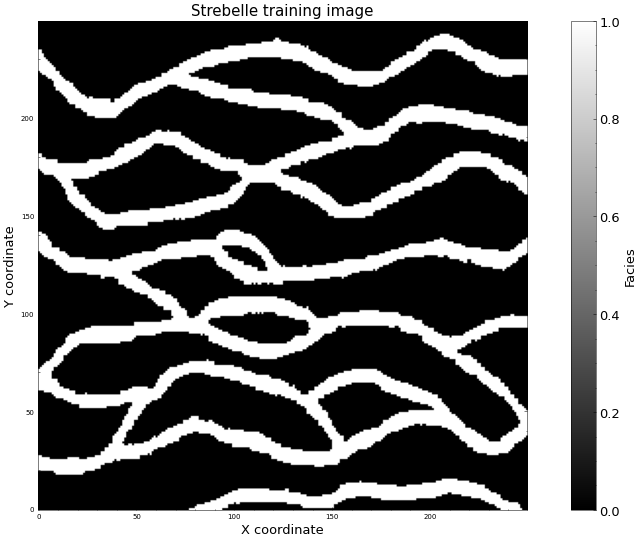

In [5]:
ti = cv2.imread('data/TI/strebelle.png')
plot_ti(ti)

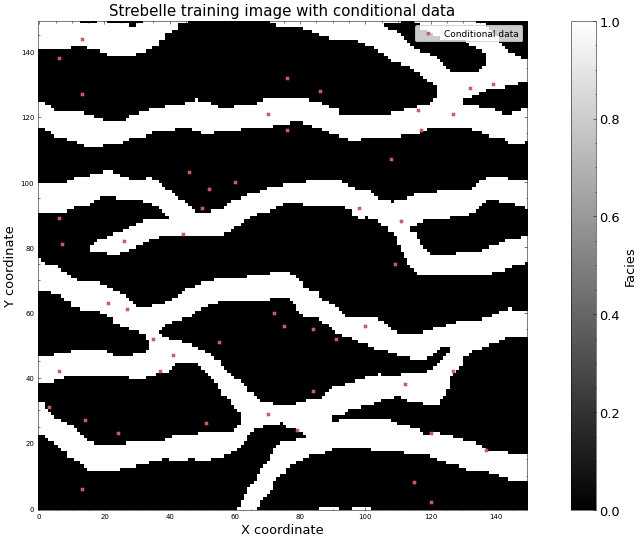

In [6]:
plot_ti_with_samples(im)

## SNESIM output

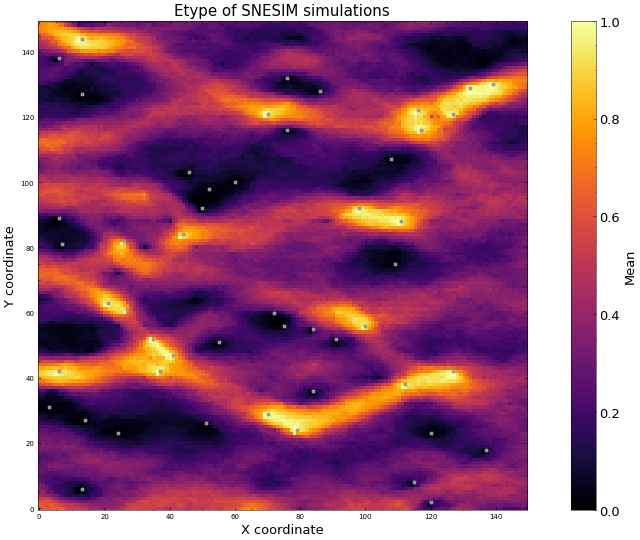

In [7]:
etype_plot(dataframe)

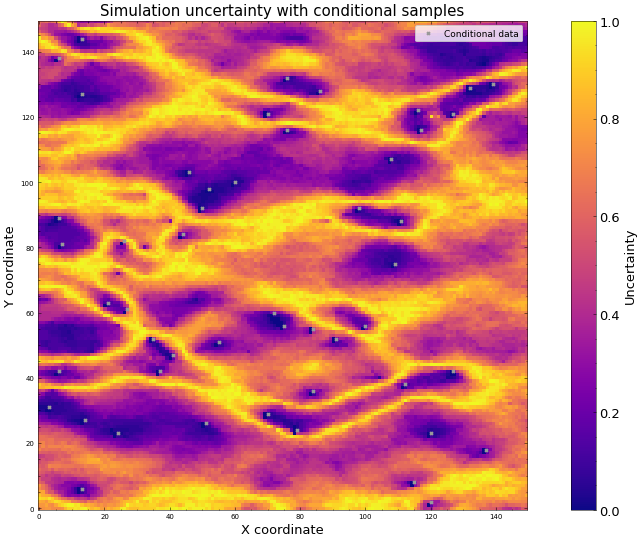

In [8]:
plot_uncertainty(dataframe)

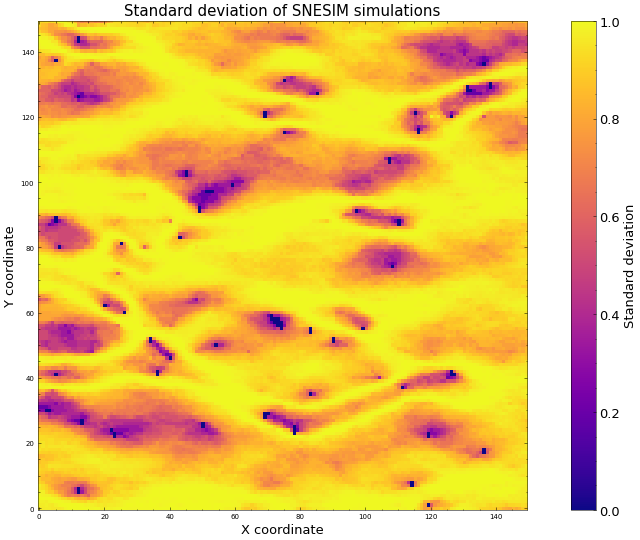

In [9]:
std_plot(dataframe)

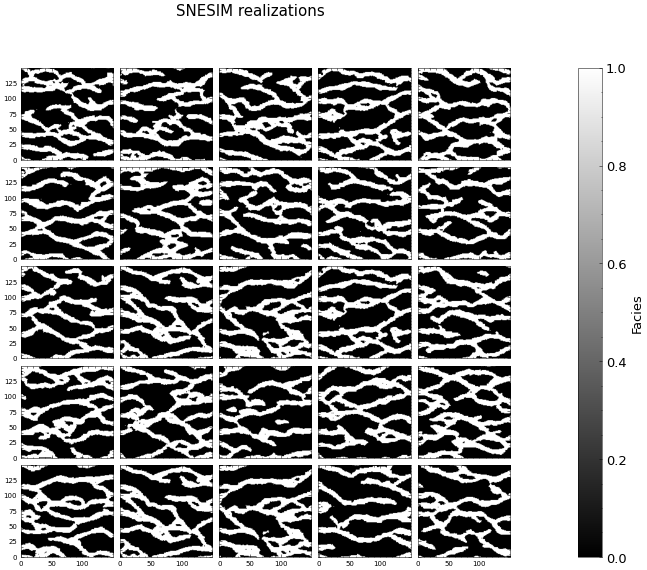

In [10]:
plot_realizations_grid(realizations)

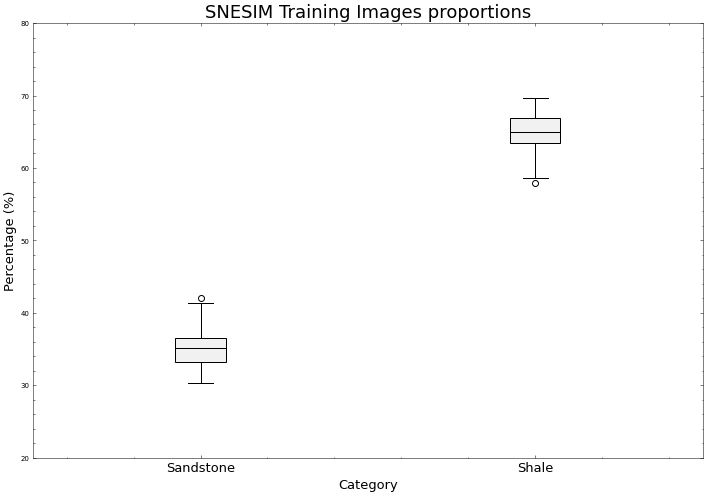

In [11]:
proportions(realizations)